In [1]:
# libraries
import os
import time

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
import sklearn
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GroupKFold,
    KFold,
    RepeatedKFold,
    ShuffleSplit,
    StratifiedShuffleSplit,
    TimeSeriesSplit,
)
from xgboost import XGBRegressor

# Set the maximum number of columns to display
pd.set_option("display.max_columns", 30)

/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
emp = pd.read_csv("employment_status.csv")
ss = pd.read_csv("SampleSubmission.csv")
income = pd.read_csv("income_group.csv")
custom = pd.read_csv("customer.csv")
transaction = pd.read_csv("transactions.csv")

In [3]:
train.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,"13,500"
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,"9,000"
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,"8,000"
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,"7,000"
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,"10,400"


In [4]:
test.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,2022-06
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,2022-01
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,2022-05
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,2022-05
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,2022-03


In [5]:
transaction.head()

,TRANSACTION_DESCRIPTION,CUSTOMER_IDENTIFIER,RECORD_DATE,ACCOUNT_TYPE_CODE,ACCOUNT_BALANCE,AMT,EVENT_NUMBER,PRODUCT_CODE,CHANNEL,ACCOUNT_NUMBER,TRANSACTION_REFERENCE
0,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-13 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,1857.56,1000.00,11785,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
1,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-02-26 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,8843.46,-2000.00,11348,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
2,POS PURCHASE,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-26 00:00:00+02:00,e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...,23.82,-199.98,148,CHEQ,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,04ae923a903fb07b5c846eb61eda25c4766800f02c2e09...
3,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-03-27 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,198.11,-79.39,11419,SAVE,system,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
4,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-05-06 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,13631.60,-200.00,11528,SAVE,atm,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN


In [6]:
transaction.shape, train.shape

((847544, 11), (3600, 3))

In [7]:
income.head()

,income_group_code,income_group_desc
0,0,NOT SUPPLIED
1,1,R 0 - 499
2,2,R500 - 999
3,3,"R1,000 - 1,999"
4,4,"R2,000 - 2,999"


In [8]:
income.shape

(22, 2)

In [9]:
test.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,2022-06
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,2022-01
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,2022-05
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,2022-05
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,2022-03


## Here we are going to combine train and test set to better proprocess it.

here are few thing to keep in Mind:
    1. Data leakage is something that occurs when we concatinate train and test while separatin them again
    2. We should be careful about the shape of the train and the test on split

## Here I am going to use this method

Add an indicator column while concatenating the two dataframes, so you can later seperate them again:

df = pd.concat([test.assign(ind="test"), train.assign(ind="train")])
Then later you can split them again:

test, train = df[df["ind"].eq("test")], df[df["ind"].eq("train")]


from this (Link)['https://datascience.stackexchange.com/questions/81617/how-to-combine-and-separate-test-and-train-data-for-data-cleaning']

we are going to concatinate our train and test data

In [10]:
data = pd.concat([train.assign(ind="train"), test.assign(ind="test")]).reset_index(
    drop=True
)

In [11]:
test.shape, train.shape

((1544, 2), (3600, 3))

In [12]:
data.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,"13,500",train
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,"9,000",train
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,"8,000",train
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,"7,000",train
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,"10,400",train


In [13]:
emp.head()

,employee_status_code,employee_status_desc
0,0,Resigned
1,3,Active
2,1,Inactive
3,2,Retiree


In [14]:
custom.head()

,CUSTOMER_IDENTIFIER,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,ID_00a7d65f82a6819e79c29a84e805777f0265308b655...,2022-09,1,6,4,7,51
1,ID_09651edcac6c55a5e401062b0c0ef7bbba3f3e49538...,2022-09,0,7,10,3,32
2,ID_17215674e76eb33b47c4dd3ac3392e3e8f1a34b131b...,2022-09,1,7,7,1,41
3,ID_212860dd16c79ea8eae97cc1fc181e6afd4862fceaf...,2022-09,0,13,10,1,44
4,ID_24953f74da44bd0915c4cb78c1d97cbbd66e85bbd91...,2022-08,0,13,6,1,44


In [15]:
custom.shape

(5144, 7)

In [16]:
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,0
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,0
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,0
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,0
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,0


As they told as that account number is duplicated so we are going to drop it to see if we can get the product code, channel, and amt columns on our train test.

In [17]:
transaction = transaction.drop_duplicates(["ACCOUNT_NUMBER"])
transaction.shape

(5587, 11)

In [18]:
transaction.shape

(5587, 11)

In [19]:
transaction = transaction.iloc[:5144, :]
transaction.shape

(5144, 11)

In [20]:
transaction.head()

,TRANSACTION_DESCRIPTION,CUSTOMER_IDENTIFIER,RECORD_DATE,ACCOUNT_TYPE_CODE,ACCOUNT_BALANCE,AMT,EVENT_NUMBER,PRODUCT_CODE,CHANNEL,ACCOUNT_NUMBER,TRANSACTION_REFERENCE
0,NaN,ID_017ba29a4d371608fad8313ff1d46c8bb42ef830ee0...,2022-07-13 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,1857.56,1000.00,11785,SAVE,internet,89fe98c0e6ccddcf9a0368507f02773693e01dfeb6911c...,NaN
322,POS PURCHASE,ID_0925f20edcf26977988f43469681d58441b449a88c7...,2022-06-26 00:00:00+02:00,e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...,24.59,-38.91,50,CHEQ,system,0e77f4d244bd3833b4aa54d3ed788a1d99e127b1cf63fd...,c9681cfc2cec371c82a1d38bad5fc9416868c36d17d0df...
329,NaN,ID_09b52b96ac7bc78862e8340d3a7be0fc103227f9bcc...,2022-04-30 00:00:00+02:00,e17913461e7c03cd0f2c1ac41584dcd801cb32e7f86ad9...,2175.76,-33.99,1656,SAVE,system,7d7506943996ff370ac93bf43200a318fbf291013aea9a...,NaN
553,POS PURCHASE,ID_13da6738cf3191e70f74c127b14345e4ddc9bc04adc...,2021-12-09 00:00:00+02:00,e92177da406abc0e0a5bce83e853dbdb4e792af521a0ae...,2232.80,-51.50,14761,CHEQ,system,db1d38f2520c0faeb26893765d4184bdd1c94e987ccfea...,2156f36cc7b365fc16661bef94f3a303a3fd4c47bfa242...
904,NaN,ID_1af3755a6e5931439773fcb2ec4dda1190dfd2fece3...,2022-04-27 00:00:00+02:00,9317537c2329262b5e19d3e29d23422558e519ca8ff0a8...,3102.59,-333.24,8005,SAVE,system,630aad4f576667271bf2848309e206465a343c8295480b...,NaN


In [21]:
data = data.merge(custom, on="CUSTOMER_IDENTIFIER")
data.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,"13,500",train,2022-07,0,15,7,1,45
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,"9,000",train,2022-04,0,15,5,1,32
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,"8,000",train,2022-08,0,7,7,7,59
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,"7,000",train,2022-08,1,9,14,7,57
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,"10,400",train,2022-09,0,12,11,1,29


## We are going to fix the data type of the target variable it's categorical we are converting it into int type
Here there is a problem we notice that there is **,** in our target variable I got help from this one: [Convert to Numerical](https://stackoverflow.com/questions/55557004/getting-attributeerror-float-object-has-no-attribute-replace-error-while)

In [22]:
data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(str)
data["DECLARED_NET_INCOME"] = [x.replace(",", "") for x in data["DECLARED_NET_INCOME"]]

In [23]:
data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(float)
# data["DECLARED_NET_INCOME"].apply(lambda x: str(x.replace(",", "").strip()))

In [24]:
data.shape, transaction.shape

((5144, 10), (5144, 11))

In [25]:
data.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07,13500.0,train,2022-07,0,15,7,1,45
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04,9000.0,train,2022-04,0,15,5,1,32
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06,8000.0,train,2022-08,0,7,7,7,59
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08,7000.0,train,2022-08,1,9,14,7,57
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07,10400.0,train,2022-09,0,12,11,1,29


# Saving the cleaned data as clean_data

In [26]:
data.to_csv("clearn_data.csv", index=False)

In [27]:
data.dtypes

CUSTOMER_IDENTIFIER          object
RECORD_DATE                  object
DECLARED_NET_INCOME         float64
ind                          object
DATE_LAST_UPDATED            object
SEX_CODE                      int64
INCOME_GROUP_CODE             int64
NUMBER_OF_ACCOUNTS            int64
OCCUPATIONAL_STATUS_CODE      int64
AGE                           int64
dtype: object

In [28]:
data["RECORD_DATE"] = pd.to_datetime(data["RECORD_DATE"])
data["YEAR"] = data["RECORD_DATE"].dt.year
data["MONTH"] = data["RECORD_DATE"].dt.month
data["DAY"] = data["RECORD_DATE"].dt.day
data.loc[:, "WEEKOFYEAR"] = data["RECORD_DATE"].dt.weekofyear
data.loc[:, "DAYOFWEEK"] = data["RECORD_DATE"].dt.dayofweek
data.loc[:, "WEEKEND"] = (data["RECORD_DATE"].dt.weekday >= 5).astype(int)

/tmp/ipykernel_4553/244305292.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data.loc[:, "WEEKOFYEAR"] = data["RECORD_DATE"].dt.weekofyear


In [29]:
# converting the target to numeric

# data["DECLARED_NET_INCOME"] = data["DECLARED_NET_INCOME"].astype(float)

# More features Engineering techniques

In [30]:
data.columns

Index(['CUSTOMER_IDENTIFIER', 'RECORD_DATE', 'DECLARED_NET_INCOME', 'ind',
       'DATE_LAST_UPDATED', 'SEX_CODE', 'INCOME_GROUP_CODE',
       'NUMBER_OF_ACCOUNTS', 'OCCUPATIONAL_STATUS_CODE', 'AGE', 'YEAR',
       'MONTH', 'DAY', 'WEEKOFYEAR', 'DAYOFWEEK', 'WEEKEND'],
      dtype='object')

In [31]:
data["SEX_CODE_COUNT"] = data["SEX_CODE"].map(data["SEX_CODE"].value_counts().to_dict())
data["INCOME_GROUP_CODE_COUNT"] = data["INCOME_GROUP_CODE"].map(
    data["INCOME_GROUP_CODE"].value_counts().to_dict()
)

In [32]:
data["MEAN_INCOME_GROUP_CODE_PER_MONTH"] = data["MONTH"].map(
    data.groupby("MONTH").mean()["INCOME_GROUP_CODE"]
)
data["STD_INCOME_GROUP_CODE_PER_MONTH"] = data["MONTH"].map(
    data.groupby("MONTH").std()["INCOME_GROUP_CODE"]
)
data["MAX_INCOME_GROUP_CODEr_PER_RIDER"] = data["MONTH"].map(
    data.groupby("MONTH").max()["INCOME_GROUP_CODE"]
)
data["MIN_INCOME_GROUP_CODE_PER_MONTH"] = data["MONTH"].map(
    data.groupby("MONTH").min()["INCOME_GROUP_CODE"]
)

In [33]:
data.head()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,YEAR,MONTH,DAY,WEEKOFYEAR,DAYOFWEEK,WEEKEND,SEX_CODE_COUNT,INCOME_GROUP_CODE_COUNT,MEAN_INCOME_GROUP_CODE_PER_MONTH,STD_INCOME_GROUP_CODE_PER_MONTH,MAX_INCOME_GROUP_CODEr_PER_RIDER,MIN_INCOME_GROUP_CODE_PER_MONTH
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,2022-07-01,13500.0,train,2022-07,0,15,7,1,45,2022,7,1,26,4,0,3085,451,10.868478,4.133660,21,1
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,2022-04-01,9000.0,train,2022-04,0,15,5,1,32,2022,4,1,13,4,0,3085,451,11.238782,4.244044,20,1
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,2022-06-01,8000.0,train,2022-08,0,7,7,7,59,2022,6,1,22,2,0,3085,373,10.730349,4.171514,21,0
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,2022-08-01,7000.0,train,2022-08,1,9,14,7,57,2022,8,1,31,0,0,2059,331,11.105966,4.151368,21,1
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,2022-07-01,10400.0,train,2022-09,0,12,11,1,29,2022,7,1,26,4,0,3085,438,10.868478,4.133660,21,1


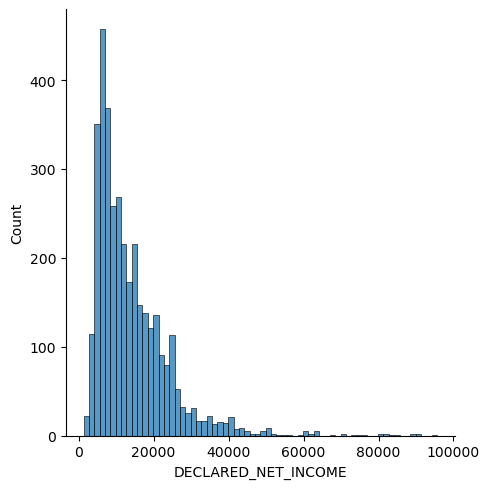

In [34]:
sns.displot(data["DECLARED_NET_INCOME"])

In [35]:
data.tail()

,CUSTOMER_IDENTIFIER,RECORD_DATE,DECLARED_NET_INCOME,ind,DATE_LAST_UPDATED,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,YEAR,MONTH,DAY,WEEKOFYEAR,DAYOFWEEK,WEEKEND,SEX_CODE_COUNT,INCOME_GROUP_CODE_COUNT,MEAN_INCOME_GROUP_CODE_PER_MONTH,STD_INCOME_GROUP_CODE_PER_MONTH,MAX_INCOME_GROUP_CODEr_PER_RIDER,MIN_INCOME_GROUP_CODE_PER_MONTH
5139,ID_dac0d34650b1f449c5a1cf4b99351bd48d0d247126d...,2022-08-01,NaN,test,2022-08,1,13,22,1,33,2022,8,1,31,0,0,2059,459,11.105966,4.151368,21,1
5140,ID_d85982b87631aab9f6f33c9a7460dd2fa738bee8bd4...,2022-04-01,NaN,test,2022-04,0,6,5,1,48,2022,4,1,13,4,0,3085,438,11.238782,4.244044,20,1
5141,ID_c5d07df4daa090d1521749243ac69ee8aecc113639d...,2022-06-01,NaN,test,2022-07,1,14,19,1,41,2022,6,1,22,2,0,2059,597,10.730349,4.171514,21,0
5142,ID_f57b72715ec759cd4ef2e208fdae0ca76a201b33009...,2022-03-01,NaN,test,2022-07,1,13,3,1,22,2022,3,1,9,1,0,2059,459,11.689655,3.953088,20,0
5143,ID_f6ab62b19e6de570ed47944399b39a50b55b7b3ed05...,2022-03-01,NaN,test,2022-07,1,16,6,1,22,2022,3,1,9,1,0,2059,403,11.689655,3.953088,20,0


In [36]:
data.drop(["RECORD_DATE", "DATE_LAST_UPDATED"], axis=1, inplace=True)
data.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME,ind,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,YEAR,MONTH,DAY,WEEKOFYEAR,DAYOFWEEK,WEEKEND,SEX_CODE_COUNT,INCOME_GROUP_CODE_COUNT,MEAN_INCOME_GROUP_CODE_PER_MONTH,STD_INCOME_GROUP_CODE_PER_MONTH,MAX_INCOME_GROUP_CODEr_PER_RIDER,MIN_INCOME_GROUP_CODE_PER_MONTH
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,13500.0,train,0,15,7,1,45,2022,7,1,26,4,0,3085,451,10.868478,4.133660,21,1
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,9000.0,train,0,15,5,1,32,2022,4,1,13,4,0,3085,451,11.238782,4.244044,20,1
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,8000.0,train,0,7,7,7,59,2022,6,1,22,2,0,3085,373,10.730349,4.171514,21,0
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,7000.0,train,1,9,14,7,57,2022,8,1,31,0,0,2059,331,11.105966,4.151368,21,1
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,10400.0,train,0,12,11,1,29,2022,7,1,26,4,0,3085,438,10.868478,4.133660,21,1


In [37]:
test, train = data[data["ind"].eq("test")], data[data["ind"].eq("train")]

In [38]:
train.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME,ind,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,YEAR,MONTH,DAY,WEEKOFYEAR,DAYOFWEEK,WEEKEND,SEX_CODE_COUNT,INCOME_GROUP_CODE_COUNT,MEAN_INCOME_GROUP_CODE_PER_MONTH,STD_INCOME_GROUP_CODE_PER_MONTH,MAX_INCOME_GROUP_CODEr_PER_RIDER,MIN_INCOME_GROUP_CODE_PER_MONTH
0,ID_18018255686b76dbc534d0edf0f7b4e9bb6cc3cde15...,13500.0,train,0,15,7,1,45,2022,7,1,26,4,0,3085,451,10.868478,4.133660,21,1
1,ID_782a96eb5b14b4cedc7df05389c6e4751c087026513...,9000.0,train,0,15,5,1,32,2022,4,1,13,4,0,3085,451,11.238782,4.244044,20,1
2,ID_fbf3035c5b8e7da652269551c78d634a48bca823076...,8000.0,train,0,7,7,7,59,2022,6,1,22,2,0,3085,373,10.730349,4.171514,21,0
3,ID_a0081832892639d933929e24ce46203ea417e17ecbe...,7000.0,train,1,9,14,7,57,2022,8,1,31,0,0,2059,331,11.105966,4.151368,21,1
4,ID_86ee557b2a4506ac40331d40370a40e37e0b95b9f23...,10400.0,train,0,12,11,1,29,2022,7,1,26,4,0,3085,438,10.868478,4.133660,21,1


In [39]:
train.shape, test.shape

((3600, 20), (1544, 20))

In [40]:
ss.shape

(1544, 2)

In [41]:
X = train.drop(["CUSTOMER_IDENTIFIER", "ind", "DECLARED_NET_INCOME"], axis=1)
y = train["DECLARED_NET_INCOME"]

In [42]:
test = test.drop(["CUSTOMER_IDENTIFIER", "ind", "DECLARED_NET_INCOME"], axis=1)
test.head()

,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,YEAR,MONTH,DAY,WEEKOFYEAR,DAYOFWEEK,WEEKEND,SEX_CODE_COUNT,INCOME_GROUP_CODE_COUNT,MEAN_INCOME_GROUP_CODE_PER_MONTH,STD_INCOME_GROUP_CODE_PER_MONTH,MAX_INCOME_GROUP_CODEr_PER_RIDER,MIN_INCOME_GROUP_CODE_PER_MONTH
3600,1,17,19,1,28,2022,6,1,22,2,0,2059,186,10.730349,4.171514,21,0
3601,0,12,11,1,40,2022,1,1,52,5,1,3085,438,12.510417,3.679230,19,5
3602,0,16,8,1,32,2022,5,1,17,6,1,3085,403,10.894358,4.188570,20,1
3603,1,2,6,1,45,2022,5,1,17,6,1,2059,30,10.894358,4.188570,20,1
3604,0,9,13,1,29,2022,3,1,9,1,0,3085,331,11.689655,3.953088,20,0


In [43]:
X.shape

(3600, 17)

In [44]:
X.head()

,SEX_CODE,INCOME_GROUP_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,YEAR,MONTH,DAY,WEEKOFYEAR,DAYOFWEEK,WEEKEND,SEX_CODE_COUNT,INCOME_GROUP_CODE_COUNT,MEAN_INCOME_GROUP_CODE_PER_MONTH,STD_INCOME_GROUP_CODE_PER_MONTH,MAX_INCOME_GROUP_CODEr_PER_RIDER,MIN_INCOME_GROUP_CODE_PER_MONTH
0,0,15,7,1,45,2022,7,1,26,4,0,3085,451,10.868478,4.133660,21,1
1,0,15,5,1,32,2022,4,1,13,4,0,3085,451,11.238782,4.244044,20,1
2,0,7,7,7,59,2022,6,1,22,2,0,3085,373,10.730349,4.171514,21,0
3,1,9,14,7,57,2022,8,1,31,0,0,2059,331,11.105966,4.151368,21,1
4,0,12,11,1,29,2022,7,1,26,4,0,3085,438,10.868478,4.133660,21,1


In [45]:
# import numpy as np

# # log and power of year

# X["AGE_LOG"] = np.log(X["AGE"])

# X["AGE_POWER"] = np.power(X["AGE"], 2)


# # same thing on test data

# test["AGE_LOG"] = np.log(test["AGE"])
# test["AGE_POWER"] = np.power(test["AGE"], 2)

In [46]:
# # adding more features
# cols = [
#     "INCOME_GROUP_CODE",
#     "NUMBER_OF_ACCOUNTS",
#     "AGE",
# ]


# def aggregate_cols(df, cols):
#     """ """
#     df["avg_meas"] = df[cols].mean(axis=1)
#     df["min_meas"] = df[cols].min(axis=1)
#     df["max_meas"] = df[cols].max(axis=1)
#     df["std_meas"] = df[cols].std(axis=1)
#     df["mad_meas"] = df[cols].mad(axis=1)
#     df["var_meas"] = df[cols].var(axis=1)
#     return df


# X = aggregate_cols(X, cols)
# test = aggregate_cols(test, cols)

In [47]:
X.dtypes

SEX_CODE                              int64
INCOME_GROUP_CODE                     int64
NUMBER_OF_ACCOUNTS                    int64
OCCUPATIONAL_STATUS_CODE              int64
AGE                                   int64
YEAR                                  int64
MONTH                                 int64
DAY                                   int64
WEEKOFYEAR                            int64
DAYOFWEEK                             int64
WEEKEND                               int64
SEX_CODE_COUNT                        int64
INCOME_GROUP_CODE_COUNT               int64
MEAN_INCOME_GROUP_CODE_PER_MONTH    float64
STD_INCOME_GROUP_CODE_PER_MONTH     float64
MAX_INCOME_GROUP_CODEr_PER_RIDER      int64
MIN_INCOME_GROUP_CODE_PER_MONTH       int64
dtype: object

In [48]:
test.dtypes

SEX_CODE                              int64
INCOME_GROUP_CODE                     int64
NUMBER_OF_ACCOUNTS                    int64
OCCUPATIONAL_STATUS_CODE              int64
AGE                                   int64
YEAR                                  int64
MONTH                                 int64
DAY                                   int64
WEEKOFYEAR                            int64
DAYOFWEEK                             int64
WEEKEND                               int64
SEX_CODE_COUNT                        int64
INCOME_GROUP_CODE_COUNT               int64
MEAN_INCOME_GROUP_CODE_PER_MONTH    float64
STD_INCOME_GROUP_CODE_PER_MONTH     float64
MAX_INCOME_GROUP_CODEr_PER_RIDER      int64
MIN_INCOME_GROUP_CODE_PER_MONTH       int64
dtype: object

**Note** <br>
With Tweedie regression and learning rate of 0.03 and max-depth of 11 score is 6413.224621

In [49]:
params = {
    "objective": "tweedie",
    "task_type": "train",
    "metric": "rmse",
    "learning_rate": 0.03,
    "sub_feature": 0.8,
    "sub_row": 0.75,
    "bagging_freq": 1,
    "lambda_l2": 0.7,
    "verbosity": 100,
    "num_iteration": 10700,
    # "n_estimators": 12244,
    # "num_leaves": 128,
    "num_leaves": 414,
    "min_data_in_leaf": 50,
    "max_depth": 13,
    "seed": 2022,
    "n_jobs": -1,
}

In [50]:
# Optuna
params_opt = {
    "objective": "tweedie",
    "n_estimators": 10400,
    "metric": "rmse",
    "reg_alpha": 0.25954252369930386,
    "reg_lambda": 0.1096067222123232,
    "colsample_bytree": 0.8,
    "subsample": 1.0,
    "learning_rate": 0.03,
    "max_depth": 11,
    "num_leaves": 128,
    # "num_leaves": 414,
    "min_child_samples": 35,
    "min_data_per_groups": 70,
    "seed": 2022,
    "n_jobs": -1,
}

In [51]:
params_trial = {
    "objective": "tweedie",
    "task_type": "train",
    "n_estimators": 18095,
    "reg_alpha": 0.0054365655449341395,
    "reg_lambda": 0.004355566459581717,
    "colsample_bytree": 0.7,
    "subsample": 0.6,
    "learning_rate": 0.01,
    "max_depth": 9,
    "num_leaves": 5,
    "min_child_samples": 29,
    "min_data_per_groups": 17,
    "seed": 42,
    "n_jobs": -1,
}

In [52]:
%%time
errcb = []
y_pred_totcb = []
fold = RepeatedKFold(n_splits=5)
i = 1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params_trial)
    # m = CatBoostRegressor()
    # m = XGBRegressor()
    m.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100,
        early_stopping_rounds=100,
    )
    preds = m.predict(X_test)
    print("err: ", metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test)
    y_pred_totcb.append(p)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
Training until validation scores don't improve for 100 rounds
[100]	training's tweedie: 462.959	valid_1's tweedie: 452.321
[200]	training's tweedie: 460.579	valid_1's tweedie: 449.641
[300]	training's tweedie: 459.95	valid_1's tweedie: 448.898
[400]	training's tweedie: 459.682	valid_1's tweedie: 448.577
[500]	training's tweedie: 459.516	valid_1's tweedie: 448.46
[600]	training's tweedie: 459.404	valid_1's tweedie: 448.398
[700]	training's tweedie: 459.315	valid_1's tweedie: 448.395
Early stopping, best iteration is:
[679]	training's tweedie: 459.333	valid_1's tweedie: 448.39
err:  6819.805339198937
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
Training until validation scores don't improve for 100 rounds
[100]	training's tweedie: 460.632	valid_1's tweedie: 460.862
[200]	training's tweedie: 458.171	valid_1's tweedie: 458.651
[300]	training's tweedie: 457.494	valid_1's tweedie: 458.175
[400]	training's tweedie: 457

In [53]:
print("The error of the model is: ", np.mean(errcb))

The error of the model is:  6352.919145504783


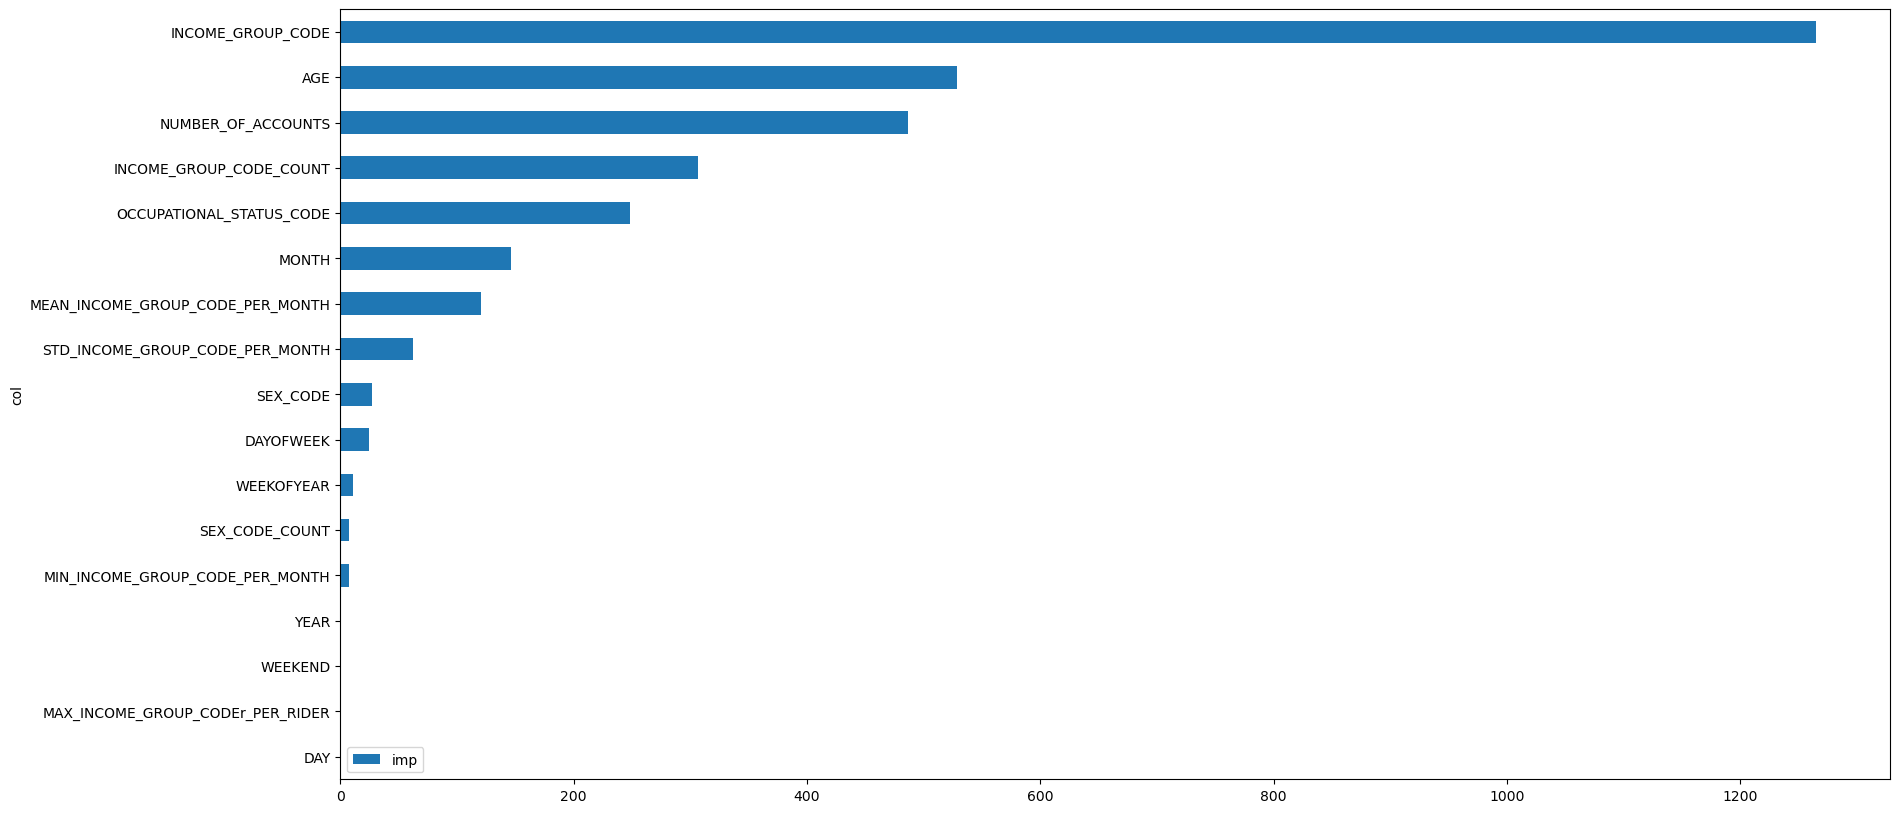

In [54]:
fea_imp = pd.DataFrame({"imp": m.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=True).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")

In [55]:
np.mean(y_pred_totcb, 0)

array([28882.07336173, 10468.61138984, 22058.80319105, ...,
       16257.41950657, 12205.91531271, 21906.14696013])

In [56]:
len(np.mean(y_pred_totcb, 0))

1544

In [57]:
test["DECLARED_NET_INCOME"] = np.mean(y_pred_totcb, 0)

In [58]:
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,0
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,0
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,0
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,0
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,0


In [59]:
ss["DECLARED_NET_INCOME"] = np.mean(y_pred_totcb, 0)
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,28882.073362
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,10468.611390
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,22058.803191
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,9865.351105
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,8051.142308


### transforming the prediction


In [60]:
# ss["DECLARED_NET_INCOME"] = np.log1p(abs(ss["DECLARED_NET_INCOME"]))

In [61]:
ss.to_csv("base_lgb.csv", index=False)

In [62]:
col2use = [
    "INCOME_GROUP_CODE",
    "SEX_CODE",
    "NUMBER_OF_ACCOUNTS",
    "OCCUPATIONAL_STATUS_CODE",
    "AGE",
    "INCOME_GROUP_CODE_COUNT",
    "MEAN_INCOME_GROUP_CODE_PER_MONTH",
    "MONTH",
]

In [63]:
X = X[col2use]
test = test[col2use]
X.head()

,INCOME_GROUP_CODE,SEX_CODE,NUMBER_OF_ACCOUNTS,OCCUPATIONAL_STATUS_CODE,AGE,INCOME_GROUP_CODE_COUNT,MEAN_INCOME_GROUP_CODE_PER_MONTH,MONTH
0,15,0,7,1,45,451,10.868478,7
1,15,0,5,1,32,451,11.238782,4
2,7,0,7,7,59,373,10.730349,6
3,9,1,14,7,57,331,11.105966,8
4,12,0,11,1,29,438,10.868478,7


In [64]:
# We are checking the variance of each variable

In [65]:
# df.f_3.apply(lambda x: np.log(1 + x)).var()
X.var()

INCOME_GROUP_CODE                      17.378158
SEX_CODE                                0.240883
NUMBER_OF_ACCOUNTS                     16.833064
OCCUPATIONAL_STATUS_CODE                3.039244
AGE                                   127.234619
INCOME_GROUP_CODE_COUNT             19863.043986
MEAN_INCOME_GROUP_CODE_PER_MONTH        0.208333
MONTH                                   3.482281
dtype: float64

In [66]:
X["INCOME_GROUP_CODE_COUNT"] = X["INCOME_GROUP_CODE_COUNT"].apply(
    lambda x: np.log(1 + x)
)

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

pipeline = Pipeline(
    [
        ("scale", RobustScaler())
        # ('quantiletransform', QuantileTransformer(random_state=seed))
    ]
)

X = pd.DataFrame(columns=X.columns, data=pipeline.fit_transform(X))
test = pd.DataFrame(columns=test.columns, data=pipeline.transform(test))

In [68]:
%%time
errcb = []
y_pred_totcb = []
fold = ShuffleSplit(n_splits=5)
i = 1
for train_index, test_index in fold.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = LGBMRegressor(**params_trial)
    # m = CatBoostRegressor()
    # m = XGBRegressor()
    m.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=0,
        early_stopping_rounds=200,
    )
    preds = m.predict(X_test)
    print("err: ", metrics.mean_squared_error(y_test, preds, squared=False))
    errcb.append(metrics.mean_squared_error(y_test, preds, squared=False))
    p = m.predict(test)
    y_pred_totcb.append(p)

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
err:  6059.872843887447
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
err:  5068.706907493199
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
err:  6696.803420063706
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
err:  5337.097709373162
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
err:  6191.731382210512
CPU times: user 14.5 s, sys: 315 ms, total: 14.8 s
Wall time: 2.01 s


In [69]:
ss["DECLARED_NET_INCOME"] = np.mean(y_pred_totcb, 0)
ss.head()

,CUSTOMER_IDENTIFIER,DECLARED_NET_INCOME
0,ID_005e5c1206b2d9857432a381df19989353c3e1b6b0d...,27787.526556
1,ID_c28fb2d93c7b4be50a57aa7ebbe31a6bae33a18e1c6...,11244.393127
2,ID_94bbc5ce0228e1d25179755dacdf9fc7359a5bbc74a...,20798.296486
3,ID_41ccd69246cea3c1b4d9349f21d7af2dd092cf7eed4...,7622.318537
4,ID_09e29a91e9369a11075b1fd7fd209f3a0c96fb18432...,8744.180498


In [70]:
ss.to_csv("base_lgb_opt.csv", index=False)

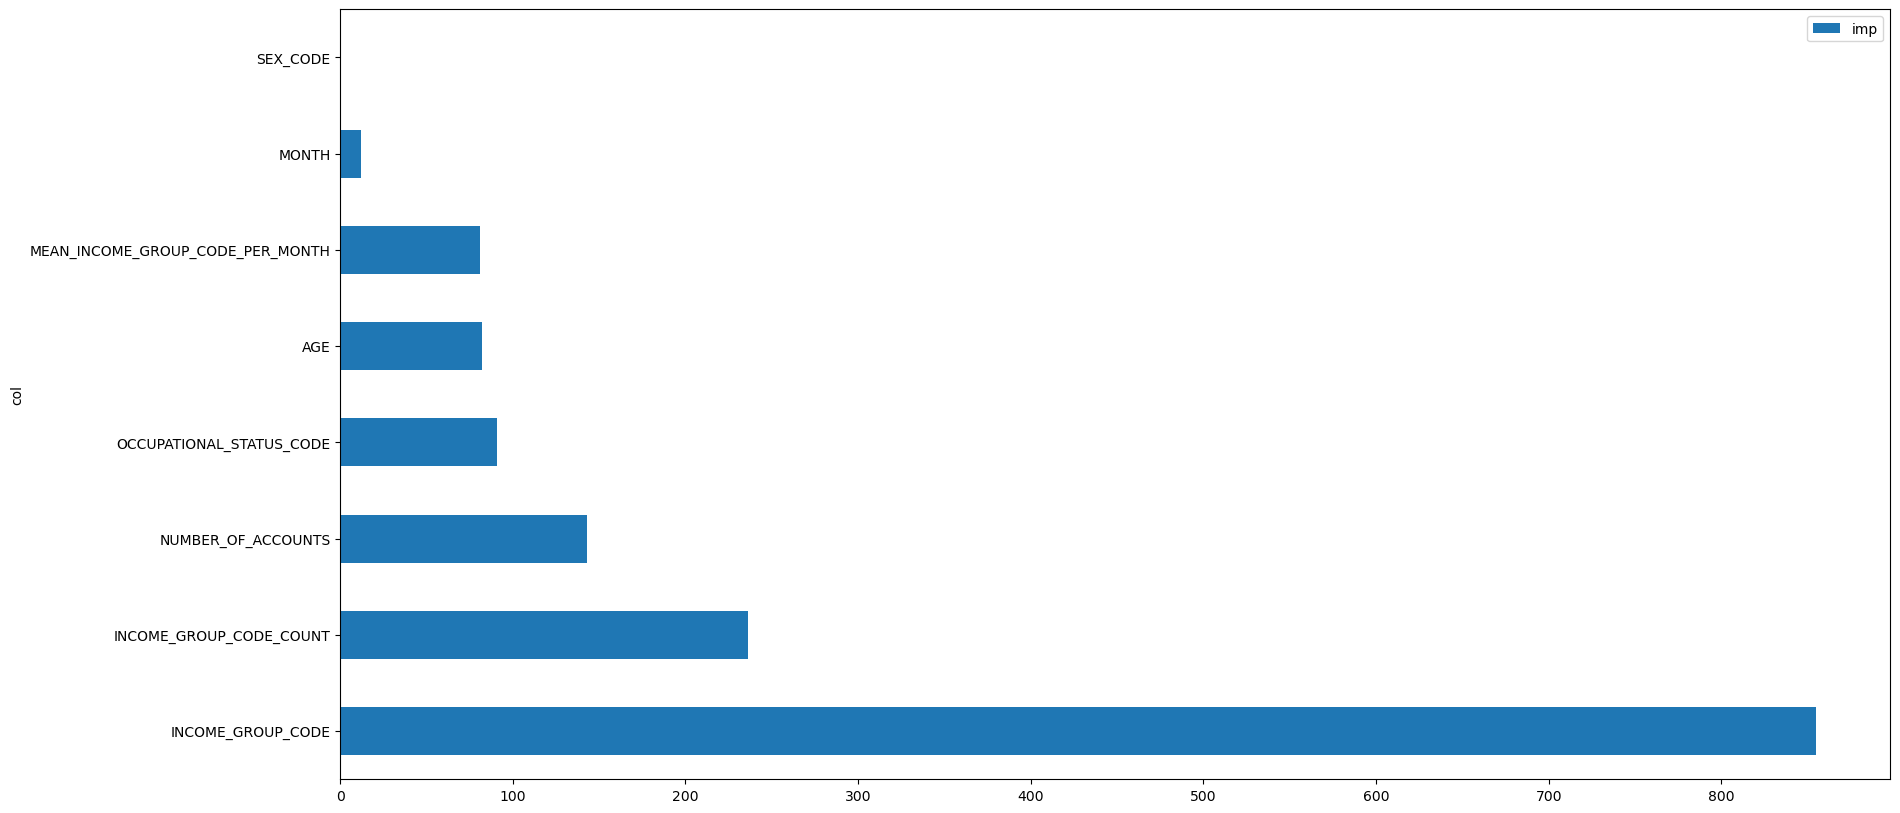

In [71]:
fea_imp = pd.DataFrame({"imp": m.feature_importances_, "col": X.columns})
fea_imp = fea_imp.sort_values(["imp", "col"], ascending=False).iloc[-30:]
_ = fea_imp.plot(kind="barh", x="col", y="imp", figsize=(20, 10))
plt.savefig("catboost_feature_importance.png")

In [72]:
ikjkjd

NameError: name 'ikjkjd' is not defined

# Using Optuna for optimization

In [ ]:
import optuna
from sklearn.model_selection import train_test_split


def objective(trial, data=X, target=y):

    train_x, test_x, train_y, test_y = train_test_split(
        data, target, test_size=0.2, random_state=42
    )
    param = {
        "metric": "rmse",
        "random_state": 42,
        # "n_estimators": 20000,
        "n_estimators": trial.suggest_int("n_estimators", 100, 100_000),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical(
            "colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        ),
        "subsample": trial.suggest_categorical(
            "subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]
        ),
        "learning_rate": trial.suggest_categorical(
            "learning_rate", [0.001, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03, 0.04, 0.05]
        ),
        "max_depth": trial.suggest_categorical(
            "max_depth",
            [
                6,
                7,
                8,
                8,
                10,
                11,
                13,
                14,
                15,
                20,
            ],
        ),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("min_data_per_groups", 1, 100),
    }
    model = LGBMRegressor(**param)

    model.fit(
        train_x,
        train_y,
        eval_set=[(test_x, test_y)],
        early_stopping_rounds=100,
        verbose=False,
    )

    preds = model.predict(test_x)

    rmse = mean_squared_error(test_y, preds, squared=False)

    return rmse

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)